In [1]:
#!/usr/bin/python
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sns
import scipy.optimize as opt
sns.set_style("ticks")

#for mem
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [3]:
df1 = pd.read_excel('data/2022-05-06 SCOPE IPDA Data.xlsx')

#adjust some columns to add logs
df1['lint1']=np.log10(df1['IntactFreq'])
df1['ltot1']=np.log10(df1['IntactFreq']+df1['Defect3Freq']+df1['Defect5Freq'])
df1['ldef1']=np.log10(df1['Defect3Freq']+df1['Defect5Freq'])

df1['time_mo_ART'] = df1['suppressYears']*12

df1.head()

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


,pid,IntactFreq,Defect3Freq,Defect5Freq,suppressYears,lint1,ltot1,ldef1,time_mo_ART
0,1079,283.861871,7356.997366,0.000000,0.000000,2.453107,3.883142,3.866701,0.000000
1,1079,16.107981,437.600138,0.000000,7.512663,1.207041,2.656777,2.641077,90.151951
2,1079,6.920407,315.147613,5.792804,10.847365,0.840132,2.515690,2.506424,130.168378
3,1079,0.000000,356.276969,18.917361,12.709103,-inf,2.574256,2.574256,152.509240
4,1098,5828.408984,1211.705014,0.000000,0.268309,3.765550,3.847580,3.083397,3.219713


In [4]:
#drop first phase, 1yr?

df1=df1[df1['suppressYears']>1]

In [5]:
long_df = pd.melt(df1,id_vars=['pid','time_mo_ART'],value_name='obs',
                  value_vars=['lint1','ldef1'],var_name='typeobs')

#deal with some negative in intacts
long_df['cens']=0
long_df['cens'].iloc[np.where(long_df['obs']==-np.inf)[0]]=0.1

long_df = long_df.replace(-np.inf,1)
long_df.to_csv('pelusolongformonolix.csv')


/Applications/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
#fit use ls

dffit = df1.replace(-np.inf,np.nan)

dffit=dffit.dropna()

minmo=12 #minimum months

dffit=dffit[dffit['time_mo_ART']>minmo]

td = dffit['time_mo_ART'].values
Id = dffit['lint1'].values
Dd = dffit['ldef1'].values
    
ts=np.linspace(minmo,240,100)

#function to output
def output_model(x):
    
    I0,D0,thI,thD,f=x
    
    I=I0*np.exp(-thI*ts)
    D=D0*np.exp(-thD*ts)
    Iobs = I + f*D
    
    return I,D,Iobs

#function to fit PK individual level data
def score_model(x):
    
    I0,D0,thI,thD,f=x
    
    I=I0*np.exp(-thI*td)
    D=D0*np.exp(-thD*td)
    Iobs = I + f*D
    
    errI = (np.log10(Iobs)-Id)**2#/np.var(Id)
    errD = (np.log10(D)-Dd)**2#/np.var(Dd)
    
    RSS = np.sqrt(np.sum(errI)+np.sum(errD))
    
    return RSS

p0= np.array([100, 1000, 0.01, 0.001, 0.05]) #initial guess of parameters
pboundz=[[1,200],[100,10000],[0.005,0.015],[0.0001,0.005],[0,0.1]]

#fit the PK data, use that the variance is in absolute units and related to concentration
res=opt.minimize(score_model,p0,bounds=pboundz,method='L-BFGS-B',tol=1e-15)


46.20981203732969 324.3997199707484


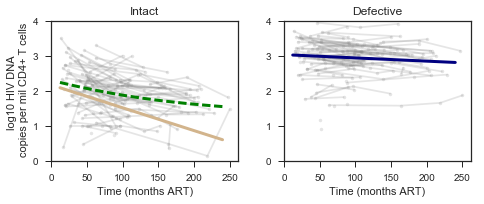

In [7]:
#myfave = [100,1000,0.01,0.001,0.05]
myfave=res.x.copy()

print(np.log(2)/res.x[2],np.log(2)/res.x[3])

I,D,Iobs = output_model(myfave)

plt.figure(figsize=(7,3))
for pid in long_df['pid'].unique():
    tdf = long_df[long_df['pid']==pid]    
    for itt,tt in enumerate(['lint1','ldef1']):
        plt.subplot(121+itt)
        plt.plot(tdf[tdf['typeobs']==tt]['time_mo_ART'],tdf[tdf['typeobs']==tt]['obs'],marker='.',alpha=0.2,color='gray')

plt.subplot(121)

plt.xlabel('Time (months ART)')
plt.ylabel('log10 HIV DNA \n copies per mil CD4+ T cells')
plt.plot(ts,np.log10(I),color='tan',lw=3)
plt.plot(ts,np.log10(Iobs),color='green',ls='--',lw=3)
plt.ylim([0,4])
plt.title('Intact')
#plt.axvline(minmo)
plt.xticks(np.arange(0,251,50))

plt.subplot(122)
plt.xlabel('Time (months ART)')
#plt.ylabel('log10 Defective HIV DNA \n copies per mil CD4+ T cells')
plt.plot(ts,np.log10(D),color='navy',lw=3)
#plt.title(int(score_model(myfave)))
plt.title('Defective')

plt.ylim([0,4])
plt.xticks(np.arange(0,251,50))

plt.tight_layout()
plt.savefig('figures/pelusofit.pdf',dpi=600)

In [56]:
#calculate the R-squared!
TSS=np.sum((Id-np.mean(Id))**2)+np.sum((Dd-np.mean(Dd))**2)

1-score_model(myfave)/TSS

0.9047599473955084

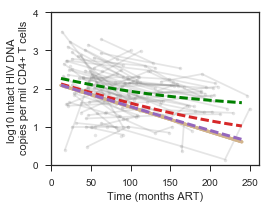

In [75]:
#use more probes

myfave=res.x.copy()
plt.figure(figsize=(4,3))
for pid in long_df['pid'].unique():
    tdf = long_df[long_df['pid']==pid]    
    plt.plot(tdf[tdf['typeobs']=='lint1']['time_mo_ART'],tdf[tdf['typeobs']=='lint1']['obs'],marker='.',alpha=0.2,color='gray')

cz=['green','tab:red','tab:purple','brown']
for iff,ff in enumerate([0.06,0.01,0.001]):

    myfave[4]=ff

    I,D,Iobs = output_model(myfave)

    plt.plot(ts,np.log10(I),color='tan',lw=3)
    plt.plot(ts,np.log10(Iobs),color=cz[iff],ls='--',lw=3)
plt.xlabel('Time (months ART)')
plt.ylabel('log10 Intact HIV DNA \n copies per mil CD4+ T cells')
plt.ylim([0,4])
plt.xticks(np.arange(0,251,50))

plt.tight_layout()
plt.savefig('figures/pelusofit_lessfalsepos.pdf',dpi=600)

In [121]:
res.x

array([1.45845391e+02, 1.07345249e+03, 1.50000000e-02, 2.13670709e-03,
       4.86420749e-02])

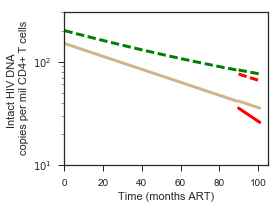

In [187]:
#show what happens if true is 2x faster

I0=1.5e2
D0=1e3
thI=np.log(2)/(4*12)
thD=2.1e-3
f=0.05

interventionmo=90

ts=np.arange(0,interventionmo)
I,D,Iobs = output_model([I0,D0,thI,thD,f])

plt.figure(figsize=(4,3))
plt.plot(ts,I,color='tan',lw=3)
plt.plot(ts,Iobs,color='green',ls='--',lw=3)
plt.xlabel('Time (months ART)')
plt.ylabel('Intact HIV DNA \n copies per mil CD4+ T cells')

ts=np.arange(0,12)
I,D,Iobs = output_model([I[-1],D[-1],thI,thD,f])
I2,D2,Iobs2 = output_model([I[-1],D[-1],thI*2,thD,f])

plt.plot(ts+interventionmo,I,color='tan',lw=3)
plt.plot(ts+interventionmo,Iobs,color='green',ls='--',lw=3)

plt.plot(ts+interventionmo,I2,color='red',lw=3)
plt.plot(ts+interventionmo,Iobs2,color='red',ls='--',lw=3)

plt.semilogy()
plt.ylim([10,3e2])
plt.xlim([0,105])
#plt.axvline(12*10)
#plt.axvline(12*11)
#plt.fill_between([100,112],[0.1,1e3])

plt.tight_layout()
plt.savefig('figures/pelusofit_therapy.pdf',dpi=600)


In [188]:
I[0]

41.48885748333125

In [203]:
np.exp(-np.log(2)/4)

0.8408964152537145

In [189]:
f*D[0]

41.476334245319975

In [191]:
#true % drop in a year
(I[0]-I[-1])/I[0]*100

14.68724647386572

In [192]:
#true % drop in a year -- therapy!
(I2[0]-I2[-1])/I2[0]*100

27.217340857890626

In [195]:
#observed % drop in a year
(Iobs[0]-Iobs[-1])/Iobs[0]*100

8.486321260614801

In [196]:
#observed % drop in a year -- therapy
(Iobs2[0]-Iobs2[-1])/Iobs2[0]*100

13.907434574584284

In [198]:
#obs difference from therapy to not after 1 year
(Iobs2[-1]-Iobs[-1])/Iobs[-1]*100

-13.907434574584284

In [199]:
#true difference from therapy to not after 1 year
(I2[-1]-I[-1])/I[-1]*100

-27.217340857890626

In [120]:
#precise calculation for 1 year study

Itrue_pct = np.exp(-np.log(2)/4*1)*100
Iobs1_pct = np.exp(-np.log(2)/4*1)+np.exp(-np.log(2)/40*1)/2*100

Itrue_therapy_pct = np.exp(-np.log(2)/2*1)*100
Iobs1_therapy_pct = np.exp(-np.log(2)/2*1)+np.exp(-np.log(2)/40*1)/2*100

print(Itrue_pct,Itrue_therapy_pct, Iobs1_pct, Iobs1_therapy_pct)

84.08964152537145 70.71067811865476 49.98192634251627 49.8481367084491


In [ ]:
#2 probes means 6% error

#what is the error of 3 probes if the third is as conserved?